## getting List of Gaming tokens
- name of the token
- market cap

In [63]:
import pandas as pd
import requests
import json
import time
import plotly.graph_objects as go
import numpy as np
from pandas.plotting import table
import dataframe_image as dfi
from adjustText import adjust_text

In [64]:
## all gaming tokens by market cap from coingecko
gaming=requests.get("https://api.coingecko.com/api/v3/coins/markets?vs_currency=USD&category=gaming&order=market_cap_desc&per_page=100&page=1&sparkline=false")
gaming_tokens=pd.json_normalize(gaming.json())
display(gaming_tokens)
## getting the id as input to get the price data
gaming_tokens_id=gaming_tokens["id"].values
## add mana 
gaming_tokens_id=np.append(gaming_tokens_id,'decentraland')
gaming_tokens_id
## store the tokens symbol
symbol=np.append(gaming_tokens.symbol.values,'mana')

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated,roi.times,roi.currency,roi.percentage
0,axie-infinity,axs,Axie Infinity,https://assets.coingecko.com/coins/images/1302...,7.243000e+01,4169510174,40,1.956162e+10,8.521413e+08,7.309000e+01,...,-10.52941,2021-08-17T13:10:20.009Z,1.237180e-01,5.830704e+04,2020-11-06T08:05:43.662Z,NaN,2021-08-20T09:50:15.251Z,NaN,NaN,NaN
1,enjincoin,enj,Enjin Coin,https://assets.coingecko.com/coins/images/1102...,1.600000e+00,1495514232,76,1.600626e+09,1.177441e+08,1.600000e+00,...,-59.47562,2021-04-09T12:29:27.777Z,1.865964e-02,8.462824e+03,2017-11-12T00:00:00.000Z,NaN,2021-08-20T09:50:33.407Z,NaN,NaN,NaN
2,ultra,uos,Ultra,https://assets.coingecko.com/coins/images/4480...,7.211700e-01,597671880,135,NaN,1.819110e+06,7.328360e-01,...,-11.81307,2021-08-14T00:59:37.091Z,2.137354e-02,3.268740e+03,2019-09-02T00:00:00.000Z,NaN,2021-08-20T09:49:29.286Z,13.423392,usd,1342.339168
3,the-sandbox,sand,The Sandbox,https://assets.coingecko.com/coins/images/1212...,5.940600e-01,526071306,140,1.782407e+09,1.240653e+08,6.008630e-01,...,-35.17231,2021-03-28T16:04:16.964Z,2.897764e-02,1.948878e+03,2020-11-04T15:59:14.441Z,NaN,2021-08-20T09:50:26.667Z,NaN,NaN,NaN
4,illuvium,ilv,Illuvium,https://assets.coingecko.com/coins/images/1446...,4.595700e+02,291724603,196,4.595709e+09,2.604376e+07,4.661800e+02,...,-15.93398,2021-08-13T22:38:29.259Z,2.923000e+01,1.468383e+03,2021-06-22T14:11:59.151Z,NaN,2021-08-20T09:49:15.676Z,NaN,NaN,NaN
5,smooth-love-potion,slp,Smooth Love Potion,https://assets.coingecko.com/coins/images/1036...,1.665110e-01,224503370,228,NaN,1.462047e+08,1.778180e-01,...,-58.20605,2021-07-13T10:04:32.975Z,3.127590e-03,5.241553e+03,2020-06-20T10:23:48.171Z,NaN,2021-08-20T09:49:57.642Z,NaN,NaN,NaN
6,my-neighbor-alice,alice,My Neighbor Alice,https://assets.coingecko.com/coins/images/1437...,1.290000e+01,224473854,229,1.290080e+09,1.339481e+08,1.314000e+01,...,-68.46091,2021-03-15T08:54:21.451Z,3.240000e+00,2.984226e+02,2021-06-22T13:54:53.068Z,NaN,2021-08-20T09:49:59.260Z,NaN,NaN,NaN
7,starlink,starl,StarLink,https://assets.coingecko.com/coins/images/1682...,1.780000e-05,174849708,273,NaN,2.788044e+07,1.844000e-05,...,-4.99066,2021-08-20T09:05:05.521Z,1.481420e-07,1.172748e+04,2021-07-01T22:57:44.002Z,NaN,2021-08-20T09:47:45.702Z,NaN,NaN,NaN
8,gala,gala,Gala,https://assets.coingecko.com/coins/images/1249...,2.051064e-02,154711930,293,1.025602e+09,2.715589e+06,2.090228e-02,...,-40.21930,2021-03-06T02:17:48.088Z,1.347500e-04,1.518008e+04,2020-12-28T08:46:48.367Z,NaN,2021-08-20T09:49:30.724Z,NaN,NaN,NaN
9,redfox-labs-2,rfox,RedFOX Labs,https://assets.coingecko.com/coins/images/1295...,7.326000e-02,98975716,387,1.457016e+08,9.601311e+06,8.762400e-02,...,-80.62533,2021-04-09T12:20:41.898Z,1.152142e-02,5.352800e+02,2020-10-28T02:58:18.806Z,NaN,2021-08-20T09:47:19.413Z,NaN,NaN,NaN


# getting past historical data
### Things to consider
- retrive market data using the gaming token ids
- each tokens must be handled separately as they don't share the same date (i.e. some are newer and vice versa)
- considering select a date range (Q1-Q2 of the price)
- CoinGecko API rate limit (50 calls per mins)
- info such as prices', 'market_caps', 'total_volumes' will be returned 
- timestamp has 3 extra 0s



In [65]:
historical_price_data={} ## store price
historical_vol_data={} ## volume
historical_mc_data={} ## marketcap
for i in gaming_tokens_id:
    url=f"https://api.coingecko.com/api/v3/coins/{i}/market_chart?vs_currency=USD&days=max&interval=daily"
    data=requests.get(url)
    ## store the price data in a dict {token:data}
    historical_price_data[i]=data.json()["prices"]
    ## store the volume data in a dict {token:data}
    historical_vol_data[i]=data.json()["total_volumes"]
    ## store the maket cap
    historical_mc_data[i]=data.json()["market_caps"]


In [66]:
## combining everyting into one dataframe
all_tokens_price_df=pd.DataFrame()
all_tokens_vol_df=pd.DataFrame()
all_tokens_mc_df=pd.DataFrame()
for i in historical_price_data:
    df = pd.DataFrame(historical_price_data[i], columns = ['ts', 'price'])
    df['ts']=pd.to_datetime(df['ts'],unit='ms').dt.date
    df.rename(columns={'price':i},inplace=True)
    df.set_index('ts',inplace=True)
    if all_tokens_price_df.empty:
        all_tokens_price_df=df
    else:
        all_tokens_price_df=all_tokens_price_df.join(df,how='left')
## combining all volume into one dataframe
for i in historical_vol_data:
    df = pd.DataFrame(historical_vol_data[i], columns = ['ts', 'volume'])
    df['ts']=pd.to_datetime(df['ts'],unit='ms').dt.date
    df.rename(columns={'volume':i},inplace=True)
    df.set_index('ts',inplace=True)
    if all_tokens_vol_df.empty:
        all_tokens_vol_df=df
    else:
        all_tokens_vol_df=all_tokens_vol_df.join(df,how='left')
## combining all prices into one dataframe marketcap
for i in historical_mc_data:
    df = pd.DataFrame(historical_mc_data[i], columns = ['ts', 'marketcap'])
    df['ts']=pd.to_datetime(df['ts'],unit='ms').dt.date
    df.rename(columns={'marketcap':i},inplace=True)
    df.set_index('ts',inplace=True)
    if all_tokens_mc_df.empty:
        all_tokens_mc_df=df
    else:
        all_tokens_mc_df=all_tokens_mc_df.join(df,how='left')
all_tokens_price_df.columns=symbol
all_tokens_vol_df.columns=symbol
all_tokens_mc_df.columns=symbol


In [67]:
## drop the columns 60% of it is empty
thresh=all_tokens_price_df.shape[0]*0.6
all_tokens_price_df.dropna(thresh=thresh,how='all',axis=1,inplace=True)
all_tokens_price_df=all_tokens_price_df.reset_index()
all_tokens_price_df['ts']=pd.to_datetime(all_tokens_price_df['ts'])
all_tokens_price_df.set_index('ts',inplace=True)


## drop the columns 60% of it is empty

all_tokens_vol_df.dropna(thresh=thresh,how='all',axis=1,inplace=True)
all_tokens_vol_df=all_tokens_vol_df.reset_index()
all_tokens_vol_df['ts']=pd.to_datetime(all_tokens_vol_df['ts'])
all_tokens_vol_df.set_index('ts',inplace=True)
##
all_tokens_mc_df.dropna(thresh=thresh,how='all',axis=1,inplace=True)
all_tokens_mc_df=all_tokens_mc_df.reset_index()
all_tokens_mc_df['ts']=pd.to_datetime(all_tokens_mc_df['ts'])
all_tokens_mc_df.set_index('ts',inplace=True)


## marketcap

In [68]:
## market cap on 12/8
mc_df=all_tokens_mc_df["2021-08-12":].T.sort_values(by="2021-08-12",ascending=False)

fig = go.Figure(go.Bar(
            x=mc_df['2021-08-12'],
            y=mc_df.index,
            orientation='h'))
fig.show()

# Data Analysis
- only consider data in 2021


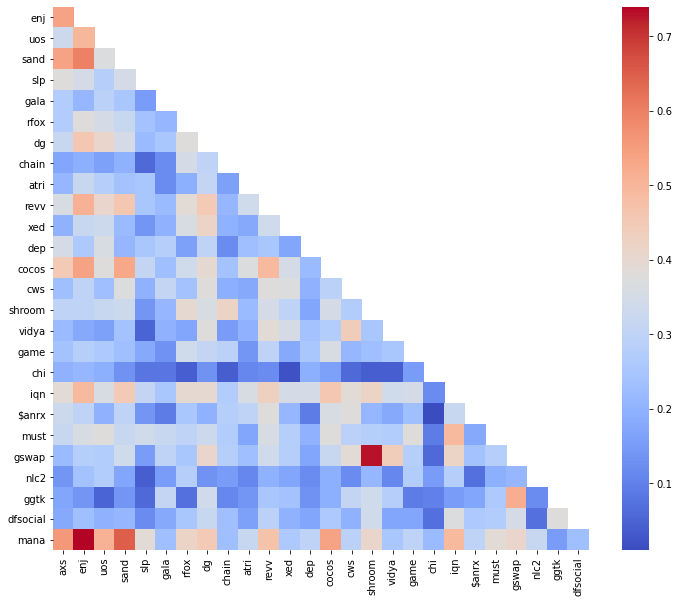

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
## token PCT_change
returns=all_tokens_price_df["2021-02":].pct_change() ## most data exist after Feb
## return correlation matrix
corr=returns.corr()
corr = np.round(corr, 2)
# plot 
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=np.bool)) 
mask = mask[1:, :-1]  
corr_new = corr.iloc[1:,:-1].copy()
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr_new, mask=mask, annot=False, fmt=".1f",cbar=True,cmap="coolwarm")
## saving the plot 
dfi.export(corr_new.iloc[:10,:10],"corr_mat.jpg")

## finding the most/least correlated pair

In [70]:
##abs correlation
abs_corr=corr_new.abs()
## highest correlated/ least correlated pairs
abs_corr.unstack().sort_values(ascending=False).drop_duplicates()[1:]


enj       mana        0.74
shroom    gswap       0.73
sand      mana        0.65
enj       sand        0.60
axs       mana        0.56
enj       cocos       0.54
sand      cocos       0.53
ggtk      gswap       0.52
enj       revv        0.51
          uos         0.50
iqn       mana        0.49
revv      mana        0.47
iqn       cocos       0.46
dg        revv        0.45
gswap     vidya       0.44
revv      iqn         0.43
shroom    iqn         0.42
revv      uos         0.41
dg        iqn         0.40
cws       gswap       0.39
          revv        0.38
iqn       dfsocial    0.37
rfox      xed         0.36
vidya     xed         0.35
revv      xed         0.34
uos       xed         0.33
dfsocial  dg          0.32
atri      dg          0.31
$anrx     atri        0.30
chain     game        0.29
game      gswap       0.28
must      dfsocial    0.27
ggtk      must        0.26
atri      slp         0.25
vidya     dep         0.24
dfsocial  chain       0.23
dg        slp         0.22
e

## clustering with Features

- annual return
- volatility
- growth 
- sharpe ratio

## finding the annual return,vol and sharpe ratio 

In [71]:
returns_annual = returns.mean() * 365  ## annualised return 
volume_avg=all_tokens_vol_df["2021-02":].mean()
market_cap=all_tokens_mc_df["2021-02":].mean()
cov_daily = returns.cov() 
cov_annual = cov_daily * len(returns.index)
weights_1 = np.identity(len(returns.columns))
returns_1 = np.dot(weights_1, returns_annual)
volatility_1 = np.sqrt(np.diagonal(cov_annual))

## covariance matrix

In [72]:
import dataframe_image as dfi
display(cov_annual)
dfi.export(cov_annual.iloc[0:10,0:10],'corrvariance_matrix.jpg')

,axs,enj,uos,sand,slp,gala,rfox,dg,chain,atri,...,game,chi,iqn,$anrx,must,gswap,nlc2,ggtk,dfsocial,mana
axs,3.767576,1.549452,0.795205,1.744248,1.944936,0.929336,0.883181,0.919438,1.002429,0.667517,...,0.855637,0.784062,0.313735,1.386462,0.953492,1.025544,0.517903,1.261532,0.881258,1.445552
enj,1.549452,2.186784,0.898796,1.470180,1.365139,0.563985,0.933051,1.024655,0.855646,0.797790,...,0.761084,0.641129,0.295618,0.968133,0.823743,0.981426,0.676305,0.769946,0.861300,1.466218
uos,0.795205,0.898796,1.498137,0.765031,0.914007,0.645390,0.720327,0.746836,0.590317,0.564309,...,0.572996,0.476599,0.182351,0.526223,0.704929,0.779046,0.630223,0.232882,0.618581,0.845174
sand,1.744248,1.470180,0.765031,2.780530,1.522824,0.759307,0.886544,0.875063,0.982790,0.653003,...,0.710897,0.458365,0.310274,1.080675,0.819647,1.322309,0.534145,0.845246,0.890801,1.461196
slp,1.944936,1.365139,0.914007,1.522824,6.989832,0.694023,1.070020,0.859775,0.478018,1.078183,...,0.862223,0.412387,0.331585,0.800277,1.376649,0.923168,0.224052,0.604787,0.793504,1.398835
gala,0.929336,0.563985,0.645390,0.759307,0.694023,3.212824,0.628340,0.679330,0.650789,0.349012,...,0.412331,0.313224,0.184961,0.331036,0.882212,1.270591,0.531760,2.037708,0.802472,0.562146
rfox,0.883181,0.933051,0.720327,0.886544,1.070020,0.628340,2.793989,0.944754,1.739808,0.527366,...,1.049079,0.124825,0.272108,0.882329,0.779481,0.983773,0.906581,0.409656,1.060917,0.942572
dg,0.919438,1.024655,0.746836,0.875063,0.859775,0.679330,0.944754,2.260260,1.346882,0.779410,...,0.844620,0.415909,0.248305,0.642124,0.766748,1.450686,0.368555,1.923248,1.224365,0.916215
chain,1.002429,0.855646,0.590317,0.982790,0.478018,0.650789,1.739808,1.346882,9.041118,0.781471,...,1.587152,0.244166,0.337985,1.836946,1.230891,2.015172,0.853702,1.265661,1.777778,0.918464
atri,0.667517,0.797790,0.564309,0.653003,1.078183,0.349012,0.527366,0.779410,0.781471,2.755741,...,0.437334,0.386370,0.245432,1.072906,0.443599,0.914366,0.350541,0.869827,0.686849,0.707378


## computing the sharpe ratio and tokens feature dataframe

In [73]:
## volatility and return (Sharpe ratio)
sharpe_ratio=(returns_1-0.01)/volatility_1
##df with all features 
tokens_feature=pd.DataFrame(index=cov_annual.index,data={"returns":returns_1,"volatility":volatility_1,"sharpe_ratio":sharpe_ratio,"volume":volume_avg.values,"market_cap":market_cap.values})
display(tokens_feature)
## saving the dataframe as jpg
dfi.export(tokens_feature, 'tokens_feature.png')


,returns,volatility,sharpe_ratio,volume,market_cap
axs,11.339194,1.941024,5.836708,4.307714e+08,6.989539e+08
enj,4.664450,1.478778,3.147498,3.813731e+08,1.494962e+09
uos,4.299296,1.223984,3.504372,2.718551e+06,3.018158e+08
sand,5.981551,1.667492,3.581157,1.728066e+08,3.151218e+08
slp,8.920724,2.643829,3.370386,5.684331e+07,6.833942e+07
gala,5.931114,1.792435,3.303391,1.103038e+06,1.342617e+08
rfox,4.601237,1.671523,2.746739,2.781599e+06,1.836951e+08
dg,4.975321,1.503416,3.302692,1.154631e+06,4.935484e+07
chain,10.336908,3.006845,3.434466,2.139043e+06,6.290993e+07
atri,0.239407,1.660042,0.138193,8.257025e+05,1.076033e+08


## clustering
- PCA 
- Elbow method

## result for using the tokens_feature dataframe

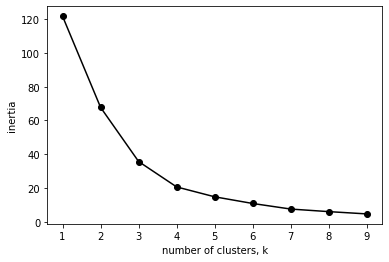

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc= StandardScaler()
## using 2 components
pca= PCA(n_components=2)
## Scaling the dataframe
sc_feature_return=sc.fit_transform(tokens_feature)
## reduced dimension
pca_return = pca.fit_transform(sc_feature_return)
pca_return_df = pd.DataFrame(pca_return,index=tokens_feature.index)
## kmean --. find the ideal num of cluster
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_return_df.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
pca_return_df 
dfi.export(pca_return_df, 'pca_return_df.png')

## plotting the clustering (n=4)

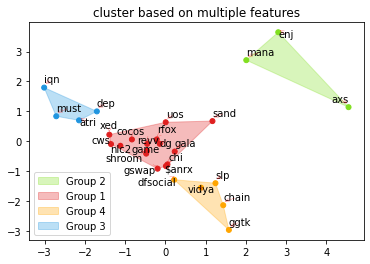

Group 1: ['uos', 'sand', 'gala', 'rfox', 'dg', 'revv', 'xed', 'cocos', 'cws', 'shroom', 'game', 'chi', '$anrx', 'gswap', 'nlc2']
Group 2: ['axs', 'enj', 'mana']
Group 3: ['atri', 'dep', 'iqn', 'must']
Group 4: ['slp', 'chain', 'vidya', 'ggtk', 'dfsocial']


In [75]:
from scipy.spatial import ConvexHull
kmeans = KMeans(n_clusters=4)
pca_return_df=pca_return_df.reset_index()
label = kmeans.fit_predict(pca_return_df.iloc[:,1:])
sym=pca_return_df["index"] ## token symbol
## pca coordinate
x=pca_return_df[0] ## x coordinate
y=pca_return_df[1] ## y coordinate
pca_return_df['label']=label
## unique group
u_labels = np.unique(label)
#plotting the results:
## define color
colors = ['#DF2020', '#81DF20', '#2095DF','#FFA500']
## color column
pca_return_df['c'] = pca_return_df.label.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3]})
## scatter plot 
plt.scatter(pca_return_df[0], pca_return_df[1], c=pca_return_df.c, alpha =1, s=25)
texts = []
for a, b, c in zip(x, y, sym):
    texts.append(plt.text(a, b+0.1, c))
## plotting convex hull
for i in pca_return_df.label.unique():
    points = pca_return_df[pca_return_df.label == i][[0, 1]].values
    # get convex hull
    if len(points)>2:
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                           points[hull.vertices,0][0])

        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i],label=f"Group {i+1}")
    else:
        
        pass


adjust_text(texts, only_move={'points':'b', 'texts':'b'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.2))
centroids = kmeans.cluster_centers_
plt.legend()
plt.title("cluster based on multiple features")
plt.show()
for i in u_labels:
    print(f"Group {i+1}:",pca_return_df[pca_return_df["label"]==i]['index'].to_list())

## Time series Daily Return Clustering



In [76]:
new_r=returns.dropna().T
display(new_r)

ts,2021-02-02,2021-02-03,2021-02-04,2021-02-05,2021-02-06,2021-02-07,2021-02-08,2021-02-09,2021-02-10,2021-02-11,...,2021-08-11,2021-08-12,2021-08-13,2021-08-14,2021-08-15,2021-08-16,2021-08-17,2021-08-18,2021-08-19,2021-08-20
axs,0.248561,-0.040286,0.064639,-0.065032,0.123932,-0.110636,0.043612,0.377721,-0.064371,0.060160,...,0.460460,0.042057,-0.006783,0.072059,-0.041784,-0.010316,-0.005551,0.068478,-0.020100,0.030564
enj,-0.002729,0.067329,0.012413,-0.019787,0.140654,-0.051893,-0.028914,0.053317,0.053555,0.008983,...,0.061935,-0.003394,-0.035274,0.064952,0.008318,-0.007606,-0.022275,-0.055541,0.000633,0.040254
uos,0.021967,0.000673,0.028165,-0.046248,0.034822,0.276810,-0.005382,0.187983,-0.034642,0.139390,...,-0.005655,0.134122,0.120462,0.169869,-0.073959,-0.033237,-0.017268,-0.085912,0.017385,0.089809
sand,-0.003780,0.147877,0.030392,0.021367,0.409000,-0.084482,-0.013841,0.087335,0.085829,-0.026897,...,0.091190,-0.010440,-0.055797,0.037065,-0.037233,0.012653,-0.015110,-0.039947,-0.036064,0.012360
slp,0.349063,0.146145,0.006145,-0.098165,0.368699,-0.153317,-0.003860,0.059969,0.093396,0.096354,...,-0.003143,-0.005038,-0.060083,0.005982,-0.059141,-0.019534,-0.019156,-0.072332,-0.014565,0.051822
gala,-0.019040,0.421517,0.643391,-0.098453,0.144208,0.232765,0.277107,0.478925,-0.108703,0.031900,...,0.112890,0.217315,-0.098221,-0.069354,-0.085849,-0.018080,0.002447,0.085277,-0.015410,0.030554
rfox,0.040609,0.112196,0.030043,-0.036063,0.010993,-0.034523,0.041230,-0.017973,0.480749,-0.000420,...,0.012877,0.308334,0.174645,0.233693,0.015829,-0.008329,-0.127206,-0.094199,0.031905,0.062150
dg,0.129401,0.126778,0.023029,-0.152042,0.163295,0.031153,-0.033834,0.136097,0.199996,0.258545,...,0.024392,0.149450,0.219761,0.109047,-0.085257,-0.018650,0.132876,-0.014319,-0.044839,0.005014
chain,0.026388,0.109138,0.139486,-0.035168,0.043053,-0.026676,-0.090189,0.091936,0.012111,-0.015144,...,-0.080559,0.218996,-0.081997,0.096853,-0.072390,0.050279,-0.053103,0.024929,0.209703,0.082608
atri,-0.021376,-0.053385,0.080058,-0.039834,0.063437,0.023417,-0.058104,0.042961,0.015120,-0.055285,...,-0.041600,0.033258,-0.043784,0.036986,-0.009296,0.047154,0.143405,-0.128141,-0.006678,0.111836


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sc= StandardScaler()
pca= PCA(n_components=2)
sc_return=sc.fit_transform(new_r)
pca_daily_return = pca.fit_transform(sc_return)
pca_daily_return_df = pd.DataFrame(pca_daily_return,index=new_r.index) ## store the x,y coordinate after pca in df 
kmeans = KMeans(n_clusters=4)
label = kmeans.fit_predict(pca_daily_return_df)
pca_daily_return_df['label']=label


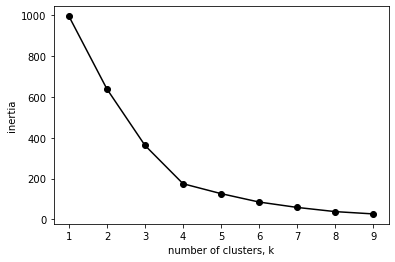

In [78]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_daily_return_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

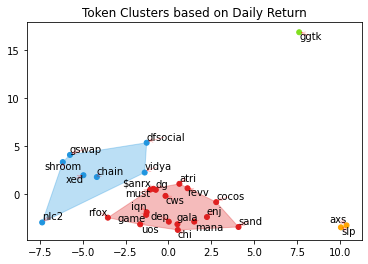

Group 1: ['enj', 'uos', 'sand', 'gala', 'rfox', 'dg', 'atri', 'revv', 'dep', 'cocos', 'cws', 'game', 'chi', 'iqn', '$anrx', 'must', 'mana']
Group 2: ['ggtk']
Group 3: ['chain', 'xed', 'shroom', 'vidya', 'gswap', 'nlc2', 'dfsocial']
Group 4: ['axs', 'slp']


In [85]:
from scipy.spatial import ConvexHull
u_labels = np.unique(label)
sym=pca_daily_return_df.index
x=pca_daily_return_df[0]
y=pca_daily_return_df[1]
## define color
colors = ['#DF2020', '#81DF20', '#2095DF','#FFA500']
pca_daily_return_df['c'] = pca_daily_return_df.label.map({0:colors[0], 1:colors[1], 2:colors[2],3:colors[3]})
plt.scatter(pca_daily_return_df[0], pca_daily_return_df[1], c=pca_daily_return_df.c, alpha =1, s=25)
texts = []
for a, b, c in zip(x, y, sym):
    texts.append(plt.text(a, b+0.1, c))

adjust_text(texts, only_move={'points':'b', 'texts':'b'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.2))


for i in pca_daily_return_df.label.unique():
    points = pca_daily_return_df[pca_daily_return_df.label == i][[0, 1]].values
    # get convex hull
    if len(points)>=3:
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                           points[hull.vertices,0][0])

        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i],label=f"Group {i}")
    else:
        
        pass

plt.title('Token Clusters based on Daily Return')
plt.show()
for i in u_labels:
    print(f"Group {i+1}:",pca_daily_return_df[pca_daily_return_df["label"]==i].index.to_list())

In [87]:
## store wthe group and token in dict
group_sym={}
for i in set(label):
    group_sym[i]=pca_daily_return_df[pca_daily_return_df.label==i].index.to_list()


## Features of each group

In [93]:
## find the mean market cap, volume ,volatility of each group
for i in group_sym:
    print (f"Group {i+1}")
    display(tokens_feature.loc[group_sym[i]].mean().reset_index())


Group 1


,index,0
0,returns,3.684594e+00
1,volatility,1.561629e+00
2,sharpe_ratio,2.238242e+00
3,volume,5.162027e+07
4,market_cap,2.228054e+08


Group 2


,index,0
0,returns,11.072418
1,volatility,3.727212
2,sharpe_ratio,2.968014
3,volume,308381.276836
4,market_cap,696341.159146


Group 3


,index,0
0,returns,5.823557e+00
1,volatility,2.281298e+00
2,sharpe_ratio,2.421708e+00
3,volume,1.058914e+06
4,market_cap,1.875895e+07


Group 4


,index,0
0,returns,1.012996e+01
1,volatility,2.292427e+00
2,sharpe_ratio,4.603547e+00
3,volume,2.438074e+08
4,market_cap,3.836466e+08
